# Deep Learning Course - Ex2
Submitted by : Idan Cohen ****** and Moshe Beutel 037580792

### imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

Define epsilon that will be used for numerical stability

In [2]:
epsilon = 1e-9  

## Part 1 - Read and visualize the data

In [3]:
train_val_ratio = 0.1
# read the data
def data_read(train_val_ratio):
    train_data = pd.read_csv('train.csv').to_numpy()
    test_data = pd.read_csv('test.csv').to_numpy()

    N = train_data.shape[0]
    indices = np.random.permutation(N)
    indices_train, indices_val = indices[:int(N * train_val_ratio)], indices[int(N * train_val_ratio):]

    x_train = train_data[indices_train, 1:]
    y_train = train_data[indices_train, 0]
    x_val = train_data[indices_val, 1:]
    y_val = train_data[indices_val, 0]
    x_test = test_data
    return x_train, y_train, x_val, y_val, x_test
	
x_train, y_train, x_val, y_val, x_test = data_read(train_val_ratio)


Preform preprocessing on the data:
1. Scaling - scale the pixel value for better numerical stability. Use min-max scaler
2. Convert labels to one-hot vector to enable vectorized calculations


In [4]:
def one_hot_encode(y):
    y_one_hot = np.zeros((y.size,10))
    y_one_hot[np.arange(y.size),y] = 1
    return y_one_hot
class MinMaxScaler():
    """
    A Min-Max Scaler that is to be fit to the train data.
    """
    def __init__(self, x_train):
        self.x_min = np.min(x_train, axis=0)
        self.x_max = np.max(x_train, axis=0)

    def scale(self, x):
        """
        A method used to scale new data based on the MinMaxScaler that was defined by the train data.
        :param x: Data matrix to be scaled
        :return: Scaled data
        """
        x_scaled = (x - self.x_min) / (self.x_max - self.x_min + epsilon)
        return x_scaled

def preprocess(x_train, y_train, x_val, y_val, x_test):
    y_train_one_hot = one_hot_encode(y_train).T
    y_val_one_hot = one_hot_encode(y_val).T

    scaler = MinMaxScaler(x_train)
    x_train = scaler.scale(x_train).T
    x_val = scaler.scale(x_val).T
    x_test = scaler.scale(x_test).T
    return x_train, y_train_one_hot, x_val, y_val_one_hot, x_test

x_train, y_train, x_val, y_val, x_test = preprocess(x_train, y_train, x_val, y_val, x_test)
	

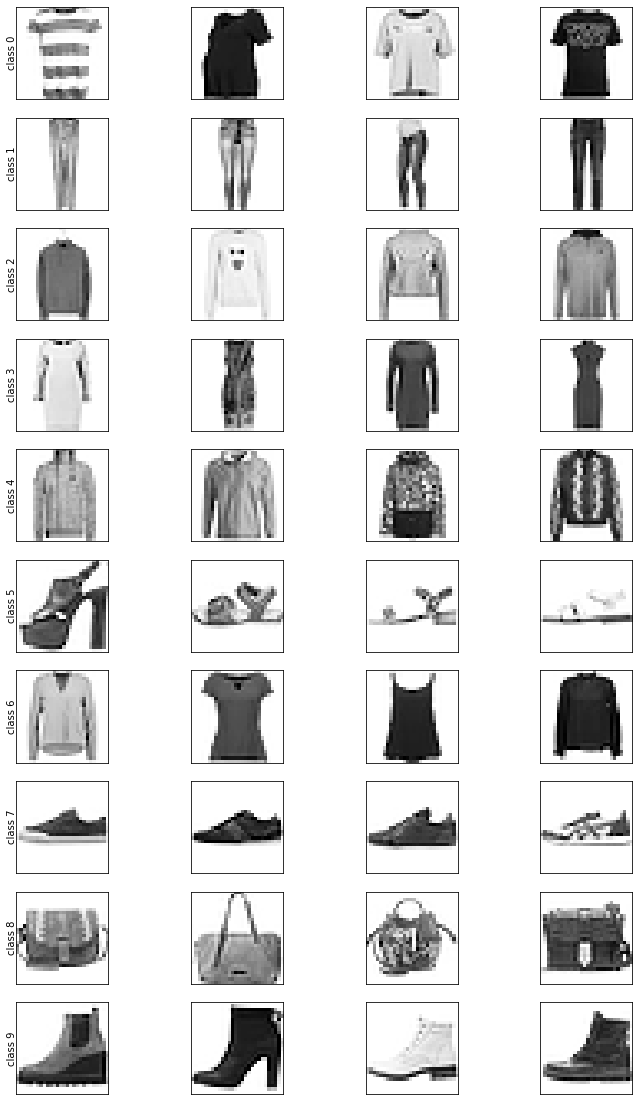

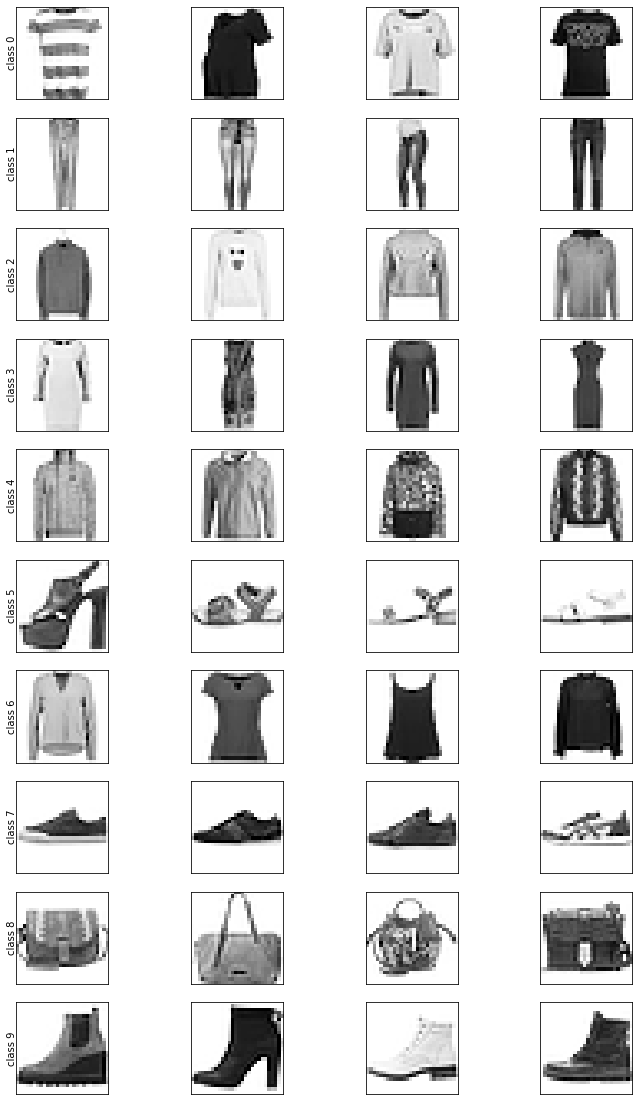

In [5]:
def visualize_data(x_train, y_train):
    fig, axes = plt.subplots(10, 4, figsize=(12, 20))
    labels = np.argmax(y_train, axis=0)
    for label in range(10):
        indices_of_label = np.where(labels == label)[0]
        for i in range(4):
            if i == 0:
                axes[label, i].set_ylabel('class '+str(label),verticalalignment='center')

            axes[label, i].imshow(x_train[:, indices_of_label[i]].reshape(28, 28), cmap='Greys')
            axes[label, i].set_xticks([])
            axes[label, i].set_yticks([])
    return fig

visualize_data(x_train, y_train)

## Part 2 - Logistic Regression

Logistic regression needs the following building blocks:
1. **Softmax** function - In order to use the Logistic regression as a classifier the logits need to be converted to probabilities over the possible classes - $p(c_{i}|X;W, b)$
2. **Cross-Entropy** loss function - The function that our model will minimize
3. **L2-Regularization** - Encourage smaller weights in order to overcome overfitting
4. **dL_dw** - The gradient of the loss with respect to the parameters

**Note:** Those buiding blocks shall be used in the neural-network as well. 

### Softmax Activation Function

$softmax(a)\dot{=}\frac{e^{a}}{\sum e^{a}}$

In exercise 1, it was proven that $softmax(x)=softmax(x+c)$ so the highest logit is substracted from all logits due to stability issues. 

In [6]:
def softmax(a):
    d = a - np.matmul(np.ones((a.shape[0], 1)) , (np.max(a, axis=0).reshape(1, a.shape[1])))
    return np.exp(d) / np.sum(np.exp(d), axis=0).reshape(1, d.shape[1])

def softmax_derivative(a):
    return a*np.eye(a.size) -  np.matmul(a,a.T)

## The Cross-Entropy Loss Function

$$L(y,\hat{y})=-\sum_{k=1}^{10}\mathbb{1}_{\{y=k\}}\log(p(y=k|x;W_{1},b_{1},W_{2},b_{2})=-\sum_{k=1}^{10}\mathbb{1}_{\{y=k\}}\log(\hat{y_{k}})$$

*averaged over all batch samples*

In [7]:
def cross_entropy_loss(softmax_z, y_true_one_hot):
    loss = np.sum(np.log(softmax_z + epsilon) * y_true_one_hot)
    return - loss / softmax_z.shape[1]

def dL_dw(softmax_z, y_true, x):
    dL = np.matmul((y_true - softmax_z), x.T)
    return - dL / softmax_z.shape[1]

## Regularization

### L2-Regularization

In [8]:
def l2_reg(w, l2_lambda):
    reg_term = l2_lambda * np.sum(np.power(w,2))
    return reg_term

def dl2_reg_dw(w, l2_lambda):
    reg_derivative = 2 * l2_lambda * w
    return reg_derivative

### L1-Regularization

In [9]:
def l1_reg(w, l1_lambda):
    reg_term = l1_lambda * np.sum(np.abs(w))
    return reg_term

def dl1_reg_dw(w, l1_lambda):
    reg_derivative = np.sign(w) * l1_lambda
    return reg_derivative

### Dropout

Droput method randomly ignores some given portion of every layer neurons. In code it done using a random binary mask applied to the layer output. At test\inference time all neurons are active but since the expected output at train time is decreased then at test time the output should be scaled down. In order to avoid changing test time code *Inverted Dropout* is implemented and a scale up is done at train time (taken from the Stanford course).

In [10]:
def dropout_mask(layer_shape, keep_prob=0.5):
    dropout_mask = (np.random.rand(*layer_shape) < dropout_keep_prob) / dropout_keep_prob 
    return dropout_mask

## Define the logistic regression process and test

In [11]:
def logistic_regression(x_train, y_train, x_val, y_val, x_test, batch_size, lr, epochs, l2_lambda, l1_lambda=0.0):
    # add a feature for the bias

    x_train_full = np.vstack([x_train, np.ones([1, x_train.shape[1]])])
    x_val_full = np.vstack([x_val, np.ones([1, x_val.shape[1]])])
    x_test_full = np.vstack([x_test, np.ones([1, x_test.shape[1]])])

    N = x_train_full.shape[1]
    w_dim = x_train_full.shape[0]

    w = np.random.normal(loc=0.0, scale=0.01,
                         size=(10, w_dim))  # initialize weights iid from a gaussian with small noise
    train_losses, train_accuracy, val_losses, val_accuracy = [], [], [], []

    # iterations over entire dataset
    for epoch in tqdm(range(epochs)):
        loss = 0
        # batch iterations within each dataset iteration
        for batch_idx, idx_start in enumerate(range(0, N, batch_size)):
            idx_end = min(idx_start + batch_size, N)
            x_batch = x_train_full[:, idx_start:idx_end]  # take all data in the current batch
            y_batch = y_train[:, idx_start:idx_end]  # .reshape(-1, 1)  # take relevant labels
            # matrix-vector multiplication
            z = np.matmul(w, x_batch)
            # calc. probability of y_j = 1 for each input (batch_size,)
            softmax_z = softmax(z)

            # calculate loss

            batch_loss = cross_entropy_loss(softmax_z, y_batch) + l2_reg(w,l2_lambda) + l1_reg(w,l1_lambda)
            loss += batch_loss
            # compute gradient of the loss w.r.t w

            delta_w = dL_dw(softmax_z, y_batch, x_batch) + 2 * l2_lambda * w + dl1_reg_dw(w, l1_lambda)
            # update w
            w = w - lr * delta_w

        # validation
        val_acc, val_loss = test(x_val_full, w, l2_lambda, y_true=y_val)
        train_acc, _ = test(x_train_full, w, l2_lambda, y_true=y_train)
        # save for plotting
        train_losses.append(loss / (len(range(0, N, batch_size)) - 1))
        train_accuracy.append(train_acc)

        val_losses.append(val_loss)
        val_accuracy.append(val_acc)

    # save the test results to a file
    test_preds = test(x_test_full, w, l2_lambda, y_true=None).astype(int)
    file_name = 'lr_pred.csv'
    np.savetxt(file_name, test_preds, fmt='%i')
    return train_losses, train_accuracy, val_losses, val_accuracy

def test(x, w, l2_lambda, y_true=None):
    z = np.matmul(w, x)
    softmax_z = softmax(z)
    predictions = np.argmax(softmax_z, axis=0)
    if y_true is None:
        return predictions
    else:
        test_loss = cross_entropy_loss(softmax_z, y_true) + l2_reg(w, l2_lambda)
        accuracy = np.mean(np.equal(np.argmax(y_true, axis=0), predictions))
        return accuracy, test_loss


### Define Hyper-Parameters

In [12]:
num_epochs = 500
batch_size = 1024
lr = 1
lr = 0.1
l2_lambda = 0
l1_lambda =0.5
NN_width = 500

In [13]:
train_loss_list, train_accuracy, val_loss_list, val_accuracy =\
    logistic_regression(x_train, y_train, x_val, y_val, x_test, batch_size, lr, num_epochs, l2_lambda)

100%|██████████| 500/500 [00:24<00:00, 20.53it/s]


In [14]:
# plot the loss and accuracy

def show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, num_epochs,
                        batch_size, lr, l2_lambda, dropout_keep_prob=1, NN_width=0, figsize=(8,8)):
    fig, axes = plt.subplots(1, 2,figsize=figsize);

    axes[0].set_xlabel('epochs')
    axes[0].set_ylabel('loss')
    axes[0].plot(range(num_epochs), train_loss_list, label="Train", color='blue')
    axes[0].plot(range(num_epochs), val_loss_list, label="Validation", color='red')
    axes[0].legend()

    axes[1].set_xlabel('epochs')
    axes[1].set_ylabel('accuracy')  # we already handled the x-label with ax1
    axes[1].plot(range(num_epochs), train_accuracy, label="Train", color='blue')
    axes[1].plot(range(num_epochs), val_accuracy, label="Validation", color='red')
    axes[1].legend()

    if NN_width == 0:
        fig.suptitle('Logistic Regression:\n\n learning rate = {}   |   batch size = {}   |   L2 lambda = {}'
                     .format(lr, batch_size, l2_lambda))
    else:
        fig.suptitle('Neural Network:\n\n learning rate = {}  |   batch size = {}   |   L2 lambda = {}'
                     '  |   NN width = {}    |   dropout (keep prob) = {}'.format(lr, batch_size, l2_lambda, NN_width, dropout_keep_prob))
#     return fig;

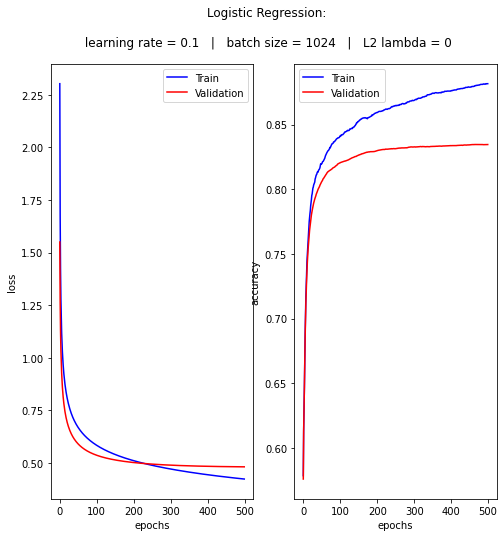

In [15]:
show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, num_epochs, batch_size, lr, l2_lambda)

## Part 3 - Neural Network

In this section a neural network will be defined and trained. 

### ReLU activation function

The ReLU function is known to be very effective acxtivation function since the gradients do not vanish like in the sigmoid function.

In [16]:
def relu(x):
    return np.maximum(x, 0)


def relu_derivative(x):
    y = np.zeros_like(x)
    y[x > 0] = 1
    return y

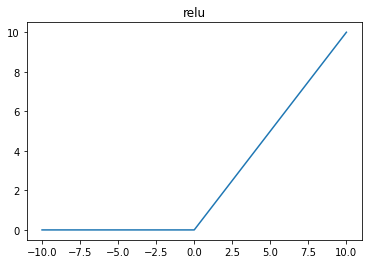

In [17]:
z = np.linspace(-10, 10, 101)  # generate 101 points evenly spaced samples on the interval [-10, 10]
s = relu(z)  # apply relu
plt.plot(z, s)
plt.title('relu');

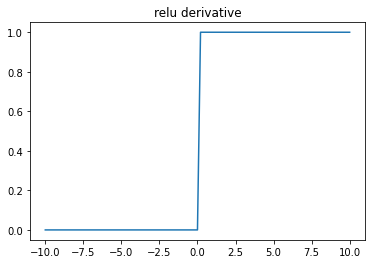

In [18]:
z = np.linspace(-10, 10, 101)  # generate 101 points evenly spaced samples on the interval [-10, 10]
s = relu_derivative(z)  # apply relu derivative
plt.plot(z, s)
plt.title('relu derivative');

### Sigmoid activation function

In [19]:
def sigmoid(z):
    return 1./(1+np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

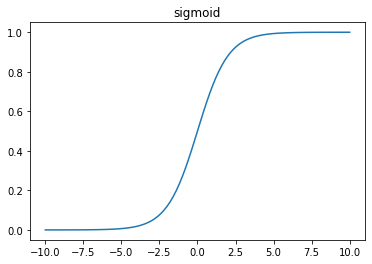

In [20]:
z = np.linspace(-10, 10, 101)  # generate 101 points evenly spaced samples on the interval [-10, 10]
s = sigmoid(z)  # apply sigmoid
plt.plot(z, s)
plt.title('sigmoid');

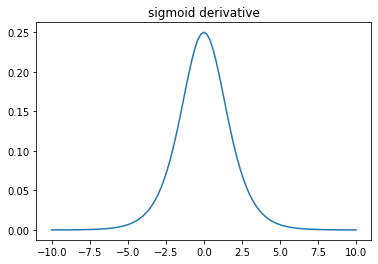

In [21]:
z = np.linspace(-10, 10, 101)  # generate 101 points evenly spaced samples on the interval [-10, 10]
s = sigmoid_derivative(z)  # apply sigmoid derivative
plt.plot(z, s)
plt.title('sigmoid derivative');

## Compute Gradients

### Output Layer derivatives

The derivative of the cross-entropy loss is just the difference between the predicted value and the true value

$$\frac{\partial L}{\partial z2}=\hat{y}-y$$

The derivative of the cross-entropy loss is just the difference between the predicted value and the true value

Since $z2=w2h+b2$, the derivative relative to $b2$ is just ones,

$$\frac{\partial z2}{\partial b2}=[1]$$

the derivative relative to $w2$ is $h$ which is the output of the hidden layer,

 $$\frac{\partial z2}{\partial w2}=h$$

and the drivative relative to $h$ is $w2$.

$$\frac{\partial z2}{\partial h}=w2$$

### Hidden Layer Derivaetives

Since $z1=w1x+b21$, the derivative relative to $b1$ is just ones, and the derivative relative to $w1$ is $x$

$$\frac{\partial z1}{\partial w1}=x$$

$$\frac{\partial z1}{\partial b1}=[1]$$

$$ \frac{\partial h}{\partial z1}=\sigma'(z1)$$

If the activation function is the sigmoid then $ \frac{\partial h}{\partial z1}=\sigma'(z1)=\sigma(z1)(1-\sigma(z1))$

But if the activation function is ReLU then $\frac{\partial h}{\partial z1}=\sigma'(z1)= 1$ if $z1 >= 0$ and $0$ otherwise

$$\frac{\partial L}{\partial z1}=\frac{\partial L}{\partial h} \cdot \frac{\partial h}{\partial z1}=\frac{\partial L}{\partial h} \cdot \sigma'$$

$$\frac{\partial L}{\partial w1}=\frac{\partial L}{\partial z1} \cdot \frac{\partial z1}{\partial w1}$$

$$\frac{\partial L}{\partial b1}=\frac{\partial L}{\partial z1} \cdot \frac{\partial z1}{\partial b1}$$

### Define the Neural Network Class

In [22]:
class NN():
    def __init__(self, NN_width, input_dim=784, act_type='relu', num_classes=10):
        assert act_type in ['relu', 'sigmoid']
        self.input_dim = input_dim
        self.w1 = 0.1*np.random.randn(NN_width, self.input_dim)
        # self.w1 = np.random.randn(NN_width, self.input_dim)
        self.b1 = np.zeros((NN_width, 1))
        self.w2 = 0.1*np.random.randn(num_classes, NN_width)
        # self.w2 = np.random.randn(10, NN_width)
        self.b2 = np.zeros((num_classes, 1))
        self.epoch = 0
        self.activation = relu if act_type == 'relu' else sigmoid 
        self.activation_derivative = relu_derivative if act_type == 'relu' else sigmoid_derivative 
            

        self.train_losses = []
        self.train_accuracy = []
        self.val_losses = []
        self.val_accuracy = []

    def train(self, x_train, y_train, x_val, y_val, batch_size, lr, num_epochs, l2_lambda=0, l1_lambda=0, dropout_keep_prob = 1):
        train_samples = x_train.shape[1]  # number of training samples
        epoch_pbar =  tqdm(range(num_epochs))
        # iterations over entire dataset
        for epoch in epoch_pbar:
            self.epoch += 1
            loss = 0
            # batch iterations within each dataset iteration
            for batch_idx, idx_start in enumerate(range(0, train_samples, batch_size)):
                idx_end = min(idx_start + batch_size, train_samples)
                x = x_train[:, idx_start:idx_end]  # take all data in the current batch
                y = y_train[:, idx_start:idx_end]  # .reshape(-1, 1)  # take relevant labels

                z1 = np.matmul(self.w1, x) + self.b1
                h = self.activation(z1)  # sigmoid / relu
                #dropout - scaled down so there is no need to change test code
                dropout_mask_1 = (np.random.rand(*h.shape) < dropout_keep_prob) / dropout_keep_prob 
                h *= dropout_mask_1
                z2 = np.matmul(self.w2, h) + self.b2
                y_pred = np.exp(z2) / (np.sum(np.exp(z2), axis=0))
                loss += cross_entropy_loss(y_pred, y) + l2_reg(self.w1, l2_lambda) + l2_reg(self.w2, l2_lambda)

                # compute gradient of the loss
                dLdz2 = y_pred - y
                dLdb2 = (1. / train_samples) * np.sum(dLdz2, axis=1, keepdims=True)
                dLdw2 = (1. / train_samples) * np.matmul(dLdz2, h.T)

                dLdh = np.matmul(self.w2.T, dLdz2)
                dLdz1 = dLdh * self.activation_derivative(z1) 
                # if dropout applied in forward prop - bakprop should mask and scale too
                dLdh *= dropout_mask_1
                dLdw1 = (1. / train_samples) * np.matmul(dLdz1, x.T)
                dLdb1 = (1. / train_samples) * np.sum(dLdz1, axis=1, keepdims=True)

                self.w2 = self.w2 - lr * (dLdw2 + 2 * l2_lambda * self.w2)
                self.b2 = self.b2 - lr * dLdb2
                self.w1 = self.w1 - lr * (dLdw1 + 2 * l2_lambda * self.w1)
                self.b1 = self.b1 - lr * dLdb1

            train_acc, train_loss = self.test(x_train, l2_lambda, y=y_train)
            val_acc, val_loss = self.test(x_val, l2_lambda, y=y_val)
#             print('Epoch:' + str(self.epoch) + '    Train Acc: ' + str(train_acc) + '    Val Acc: ' + str(val_acc))
            epoch_pbar.set_postfix({'epoch': self.epoch, 'train accuracy': train_acc, 'train loss': train_loss, \
                             'val accuracy': val_acc, 'val loss': val_loss})
            # save for plotting
            self.train_losses.append(loss / (len(range(0, train_samples, batch_size)) - 1))
            self.train_accuracy.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracy.append(val_acc)

        return self.train_losses, self.train_accuracy, self.val_losses, self.val_accuracy

    def test(self, x, l2_lambda, y=None):
        z1 = np.matmul(self.w1, x) + self.b1
        h = relu(z1)
        z2 = np.matmul(self.w2, h) + self.b2
        y_pred = np.exp(z2) / (np.sum(np.exp(z2), axis=0) + epsilon)
        predictions = np.argmax(y_pred, axis=0)
        if y is None:  # test case
            return predictions
        else:  # val case
            # calculate loss
            test_loss = cross_entropy_loss(y_pred, y) + l2_reg(self.w1, l2_lambda) + l2_reg(self.w2, l2_lambda)
            # calc. accuracy
            accuracy = np.mean(np.equal(np.argmax(y, axis=0), predictions))
            return accuracy, test_loss

    def save_test_predictions(self):
        test_predictions = self.test(x_test, l2_lambda, y=None).astype(int)
        file_name = 'NN_pred.csv'
        np.savetxt(file_name, test_predictions, fmt='%i')  # d = 500, Bsize = 1024, LR=1, epoch=50 acc = 0.83
        return


### Define Hyper-Parameters

In [25]:
num_epochs = 30  # number of times to iterate over the entire dataset
batch_size = 1024  # batch size
lr = 1
l1_lambda = 0.0
l2_lambda = 0.00001
NN_width = 500  # NN layer size
dropout_keep_prob=0.5

### Train and Test the Neural Network

In [26]:
nn = NN(NN_width, act_type='relu')
train_loss_list, train_accuracy, val_loss_list, val_accuracy = nn.train(x_train, y_train, x_val, y_val, batch_size, lr, num_epochs, l2_lambda, l1_lambda, dropout_keep_prob=dropout_keep_prob )

100%|██████████| 500/500 [05:42<00:00,  1.46it/s, epoch=500, train accuracy=0.971, train loss=0.145, val accuracy=0.863, val loss=0.463]


### Plot Learning Curve - Loss and Accuracy

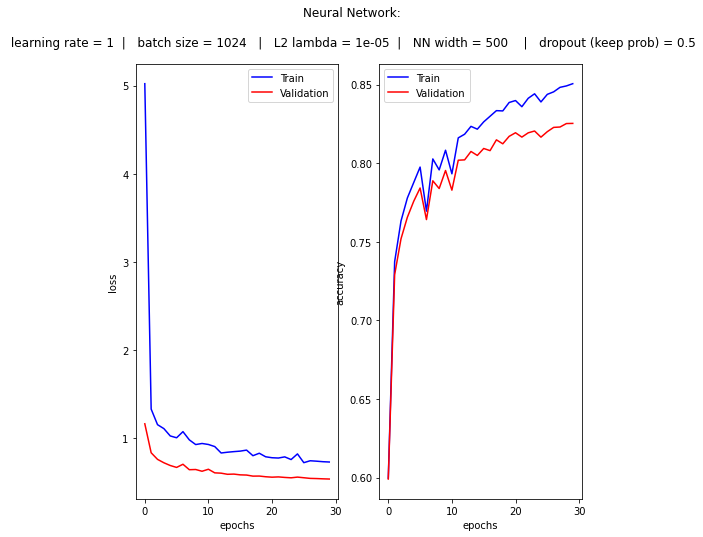

In [29]:
show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, nn.epoch, batch_size, lr, l2_lambda, NN_width=NN_width, dropout_keep_prob=dropout_keep_prob)

In [30]:
nn.save_test_predictions()

## Hyper-Parameter Tuning

### num_epochs

It can be seen that the learning curve does not achive plateau so the number of epochs can be increased

In [31]:
num_epochs = 300

100%|██████████| 300/300 [03:38<00:00,  1.37it/s, epoch=300, train accuracy=0.948, train loss=0.213, val accuracy=0.86, val loss=0.448] 


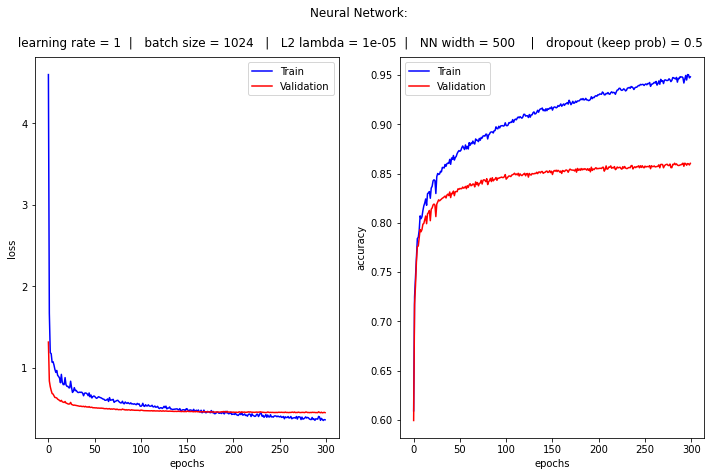

In [32]:
nn = NN(NN_width, act_type='relu')
train_loss_list, train_accuracy, val_loss_list, val_accuracy = nn.train(x_train, y_train, x_val, y_val, batch_size, lr, num_epochs, l2_lambda, dropout_keep_prob=dropout_keep_prob )
show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, nn.epoch, batch_size, lr, l2_lambda, NN_width=NN_width, dropout_keep_prob=dropout_keep_prob, figsize=(12,7))

The loss graph shows that after about 200 epochs train loss is lower than validation loss. Validation loss is computed at the end of epoch after all backprops of the running epoch. Therefore it should have loss level like end of epoch train. 

### Activation Function

Try using the sigmoid function instead  of ReLU

100%|██████████| 300/300 [03:54<00:00,  1.28it/s, epoch=300, train accuracy=0.715, train loss=1.08, val accuracy=0.703, val loss=1.15]


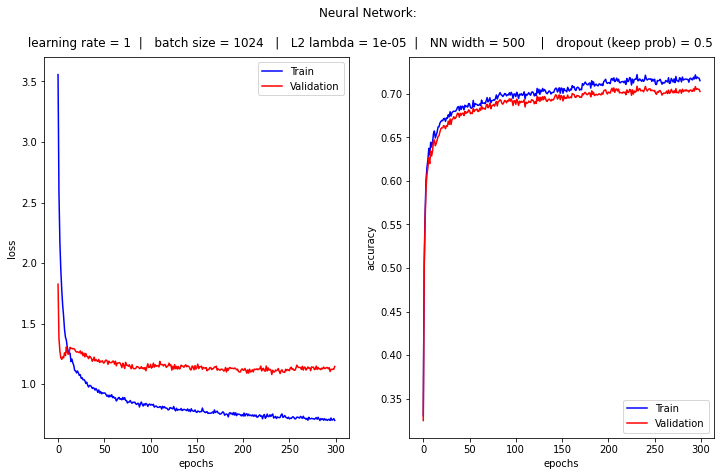

In [33]:
nn = NN(NN_width, act_type='sigmoid')
train_loss_list, train_accuracy, val_loss_list, val_accuracy = nn.train(x_train, y_train, x_val, y_val, batch_size, lr, num_epochs, l2_lambda, dropout_keep_prob=dropout_keep_prob )
show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, nn.epoch, batch_size, lr, l2_lambda, NN_width=NN_width, dropout_keep_prob=dropout_keep_prob, figsize=(12,7))

It is clear that sigmoid performence is worse than ReLU.

### Neural Network Width

Try to change hidden layer width. The more neurons the more feature the net learns. Too many features cause overfitting.On the other hand too few neurons do not capture all important features that diffrentiate between the classes.

In [34]:
num_epochs = 300  # number of times to iterate over the entire dataset
batch_size = 1024  # batch size
lr = 1
l2_lambda = 0.00001
dropout_keep_prob=0.5

100%|██████████| 300/300 [04:52<00:00,  1.03it/s, epoch=300, train accuracy=0.958, train loss=0.204, val accuracy=0.862, val loss=0.461]


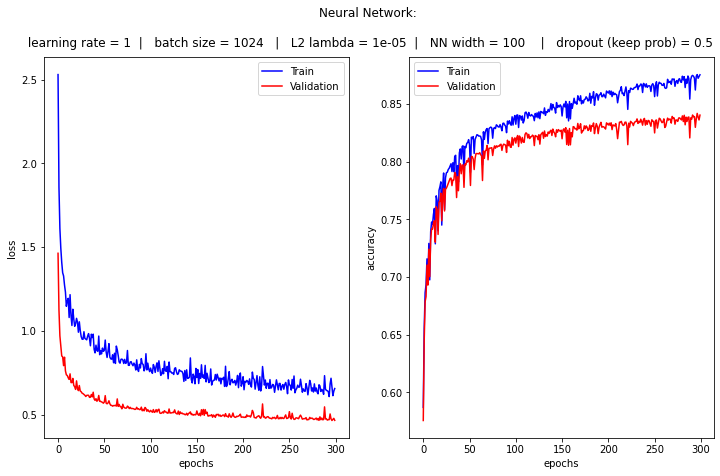

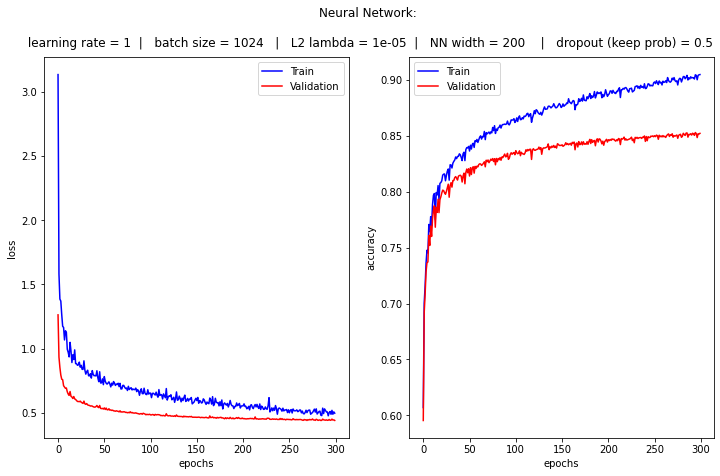

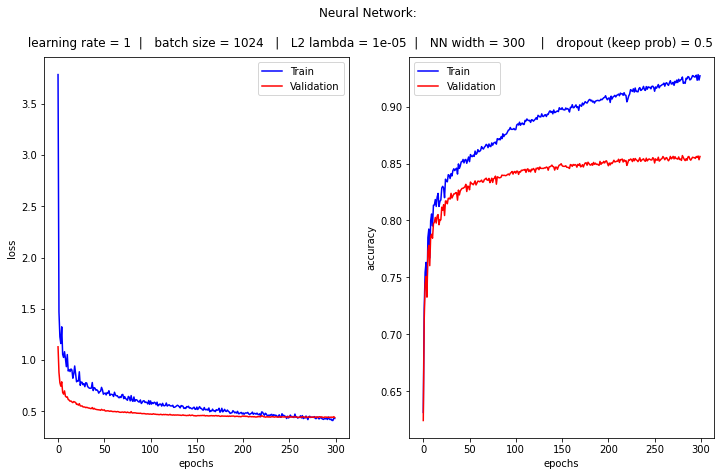

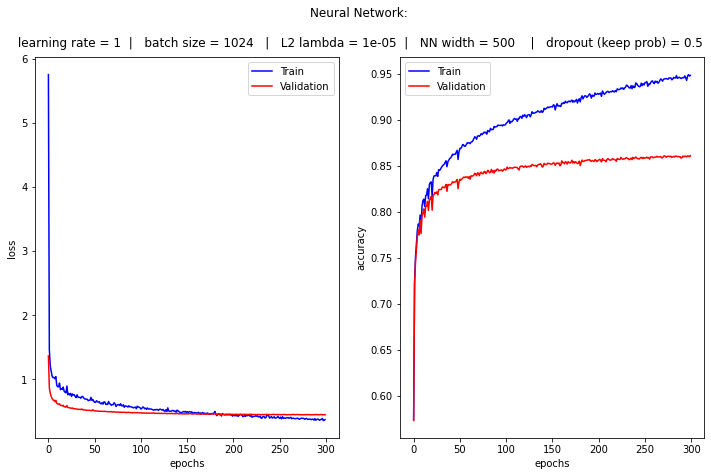

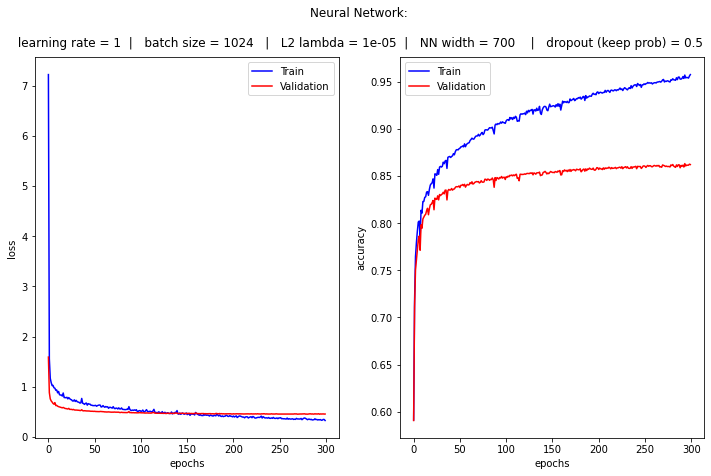

In [35]:
nn_width_list = [100,200, 300, 500, 700]
for w in nn_width_list:
    nn = NN(w, act_type='relu')
    train_loss_list, train_accuracy, val_loss_list, val_accuracy = nn.train(x_train, y_train, x_val, y_val, batch_size, lr, num_epochs, l2_lambda, dropout_keep_prob=dropout_keep_prob )
    show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, nn.epoch, batch_size, lr, l2_lambda, NN_width=w, dropout_keep_prob=dropout_keep_prob,figsize=(12,7))

A width of 300 achieves optimal validation accuracy with minimum variations.

### Hyper Parameter Tuning Function

For the rest of the hyper-parameter tuning the folloing function will be used

In [36]:

def tune_hyper_param(x_train, y_train, x_val, y_val, param_name_to_tune, param_val_list, NN_width=400, batch_size=1024, lr=1, num_epochs=200, l2_lambda=0.00001, l1_lambda=0.0, dropout_keep_prob=0.5):
    locs = locals()
    del locs['param_name_to_tune']
    del locs['param_val_list']
    del locs['NN_width']
    train_losses, train_accs, val_losses, val_accs = [],[],[],[]
    for val in param_val_list:
        nn = NN(NN_width, act_type='relu')
        locs[param_name_to_tune] = val
        train_loss_list, train_accuracy, val_loss_list, val_accuracy = nn.train(**locs)
        train_losses.append(train_loss_list[-1])
        train_accs.append(train_accuracy[-1])
        val_losses.append(val_loss_list[-1])
        val_accs.append(val_accuracy[-1])
        show_learning_curve(train_loss_list, val_loss_list, train_accuracy, val_accuracy, nn.epoch,\
                            batch_size=locs['batch_size'], lr=locs['lr'], l2_lambda=locs['l2_lambda'], NN_width=NN_width, dropout_keep_prob=locs['dropout_keep_prob'], figsize=(12,7))
    fig, axes = plt.subplots(1, 2, figsize=(8,8));

    axes[0].set_xlabel(f'{param_name_to_tune} in training')
    axes[0].set_ylabel('loss')
    axes[0].plot(param_val_list, train_losses, label="Train", color='blue')
    axes[0].plot(param_val_list, val_losses, label="Validation", color='red')
    axes[0].legend()

    axes[1].set_xlabel(f'{param_name_to_tune} in training')
    axes[1].set_ylabel('accuracy')  # we already handled the x-label with ax1
    axes[1].plot(param_val_list, train_accs, label="Train", color='blue')
    axes[1].plot(param_val_list, val_accs, label="Validation", color='red')
    axes[1].legend()

    fig.suptitle('Neural Network:\n\n learning rate = {}  |   batch size = {}   |   L2 lambda = {}'
                 '  |   NN width = {}    |   dropout (keep prob) = {}'.format(lr, batch_size, l2_lambda, NN_width, dropout_keep_prob))

### Batch Size

Batch size of 1024 is a bit large. Decreasing it may cause more variations and it is related to learning rate

100%|██████████| 200/200 [01:56<00:00,  1.72it/s, epoch=200, train accuracy=0.917, train loss=0.285, val accuracy=0.853, val loss=0.451]


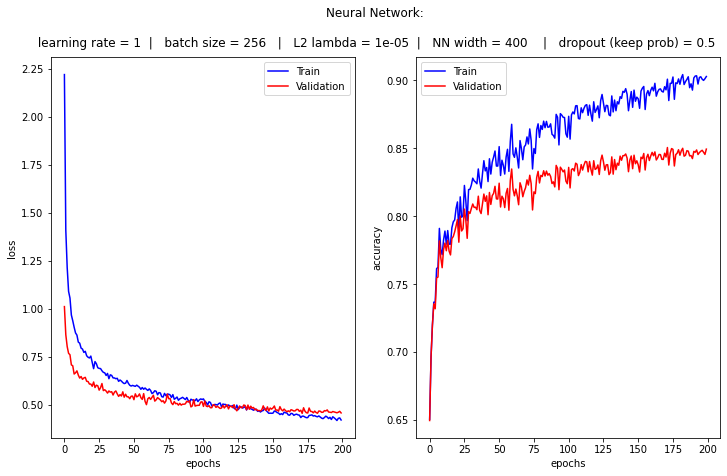

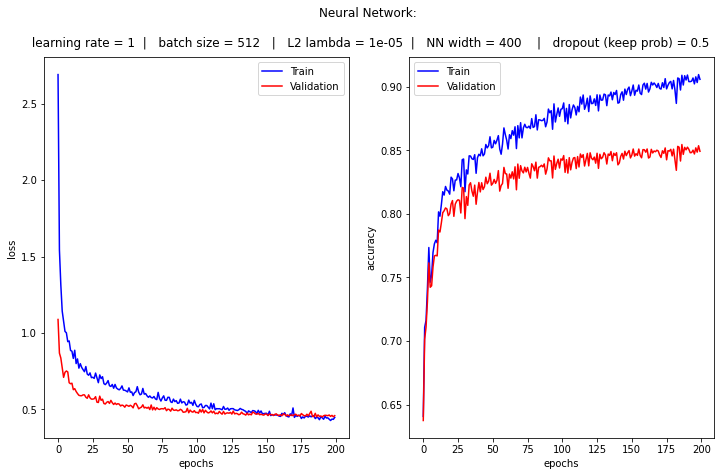

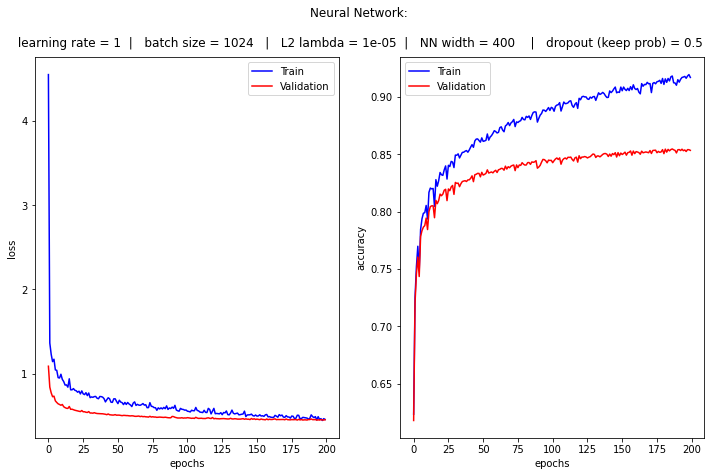

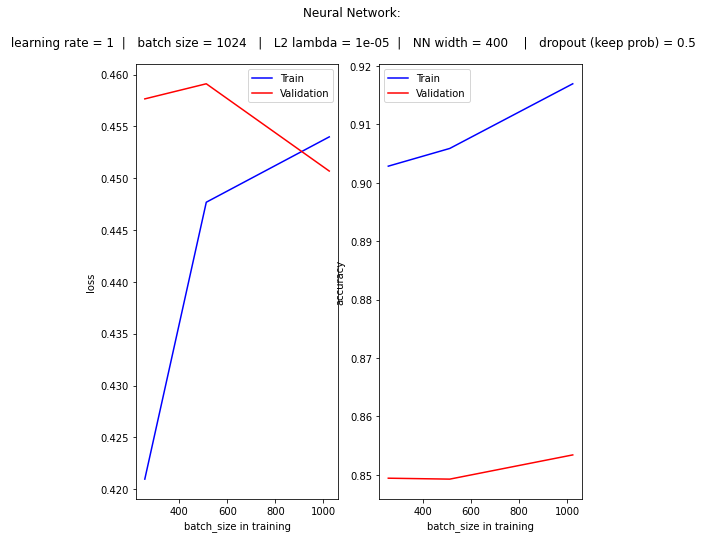

In [37]:
batch_sizes = [256,512,1024]
tune_hyper_param(x_train, y_train, x_val, y_val, 'batch_size', batch_sizes)

As expected, variations increased because the gradients are averaged over less samples.

### Learning Rate

Reducing the learning rate may decrease variations and has similar effect to inreasing the batch size. May prevent getting stuck in local minima.

100%|██████████| 300/300 [02:55<00:00,  1.71it/s, epoch=300, train accuracy=0.939, train loss=0.231, val accuracy=0.861, val loss=0.439]


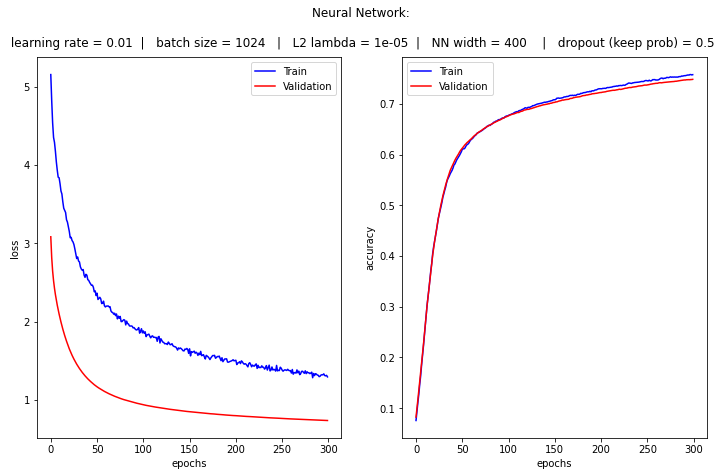

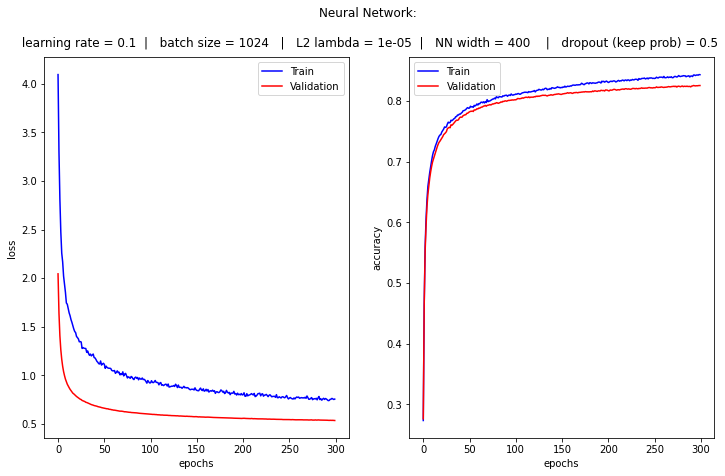

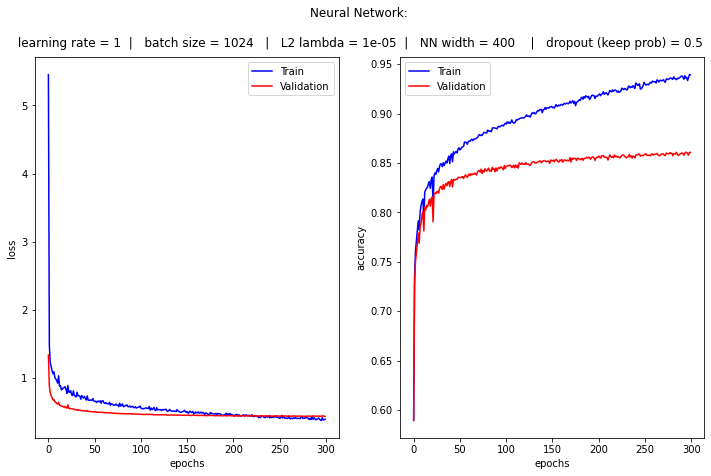

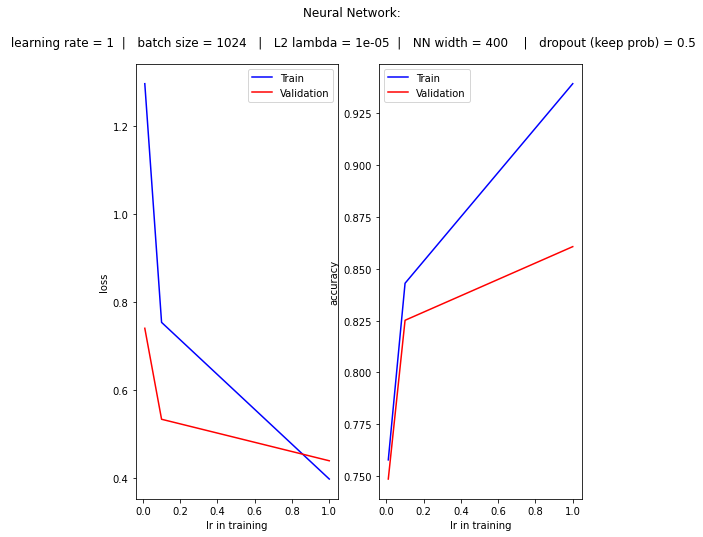

In [38]:
learning_rate_list = [0.01,0.1,1]
tune_hyper_param(x_train, y_train, x_val, y_val,'lr',learning_rate_list, num_epochs=300)

### Dropout Keep Prob

100%|██████████| 300/300 [02:54<00:00,  1.72it/s, epoch=300, train accuracy=0.967, train loss=0.131, val accuracy=0.861, val loss=0.415]


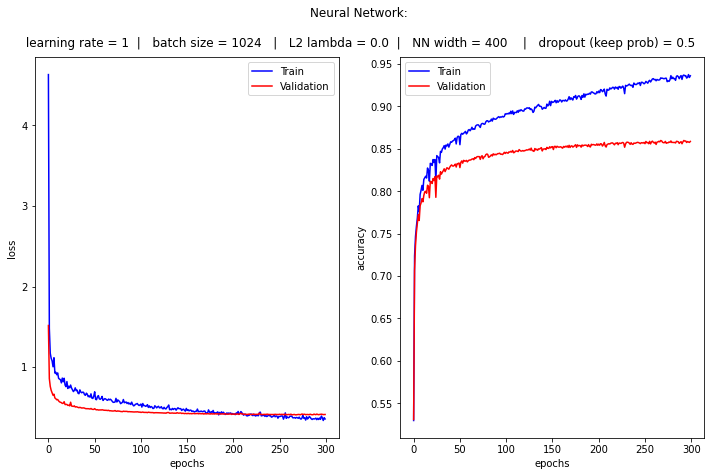

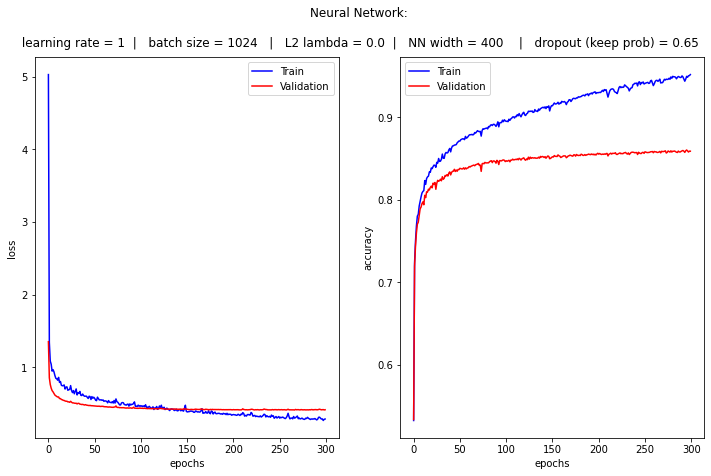

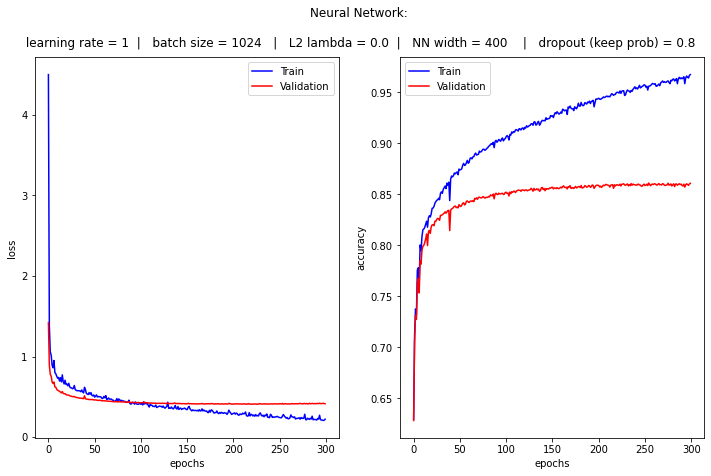

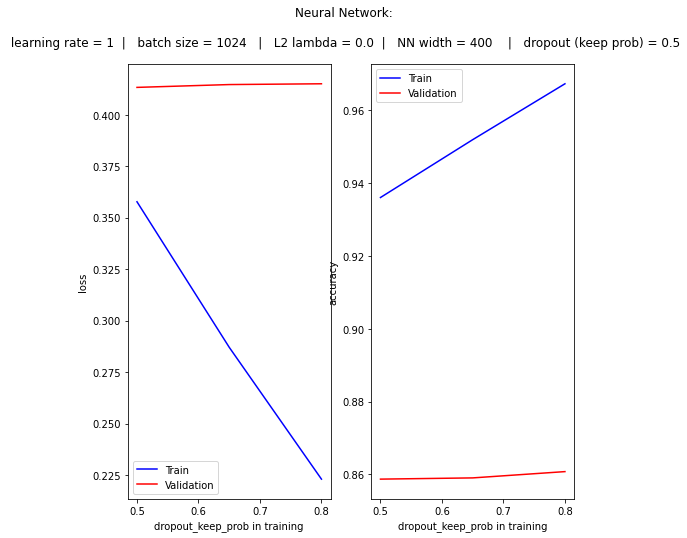

In [39]:
dropout_keep_prob_list = [0.5,0.65,0.8]
tune_hyper_param(x_train, y_train, x_val, y_val,'dropout_keep_prob',dropout_keep_prob_list, l2_lambda=0.0, num_epochs=300)

At more than `dropout_keep_prob = 0.5` improvements in training has no effect on validation and that seems to show the model is overfitting on train data

### L2 Lambda

100%|██████████| 300/300 [02:43<00:00,  1.83it/s, epoch=300, train accuracy=0.723, train loss=1.02, val accuracy=0.725, val loss=1.02]


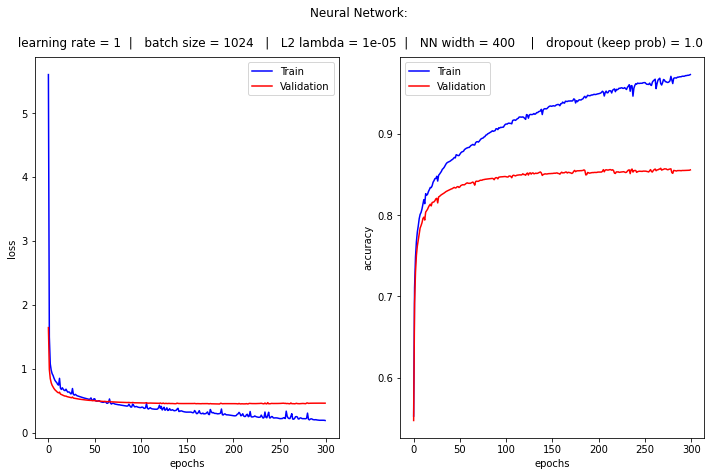

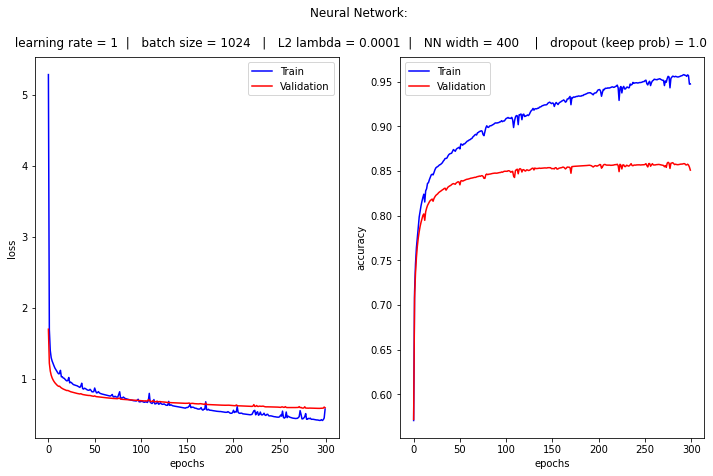

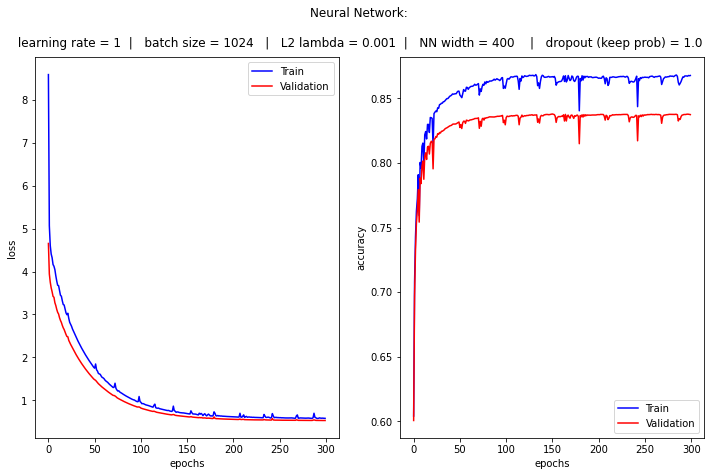

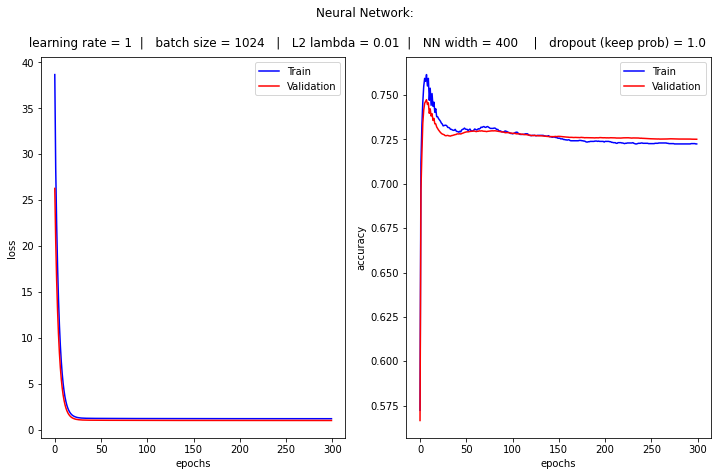

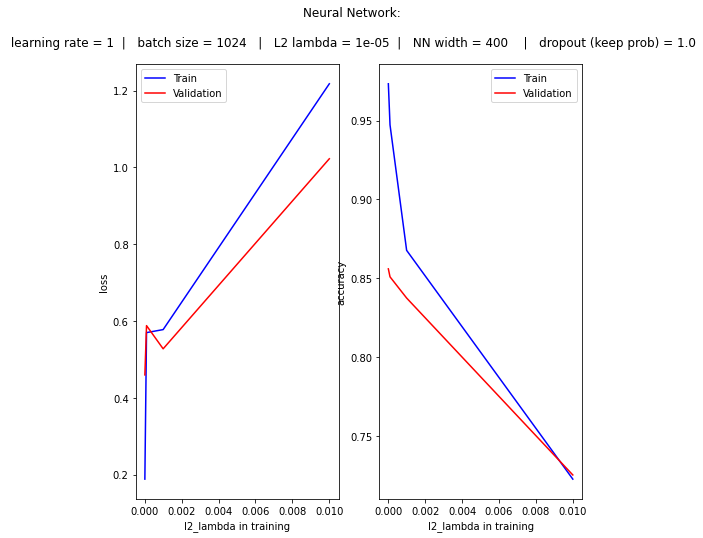

In [40]:
l2_lambda_list = [0.00001, 0.0001,0.001, 0.01]
tune_hyper_param(x_train, y_train, x_val, y_val,'l2_lambda',l2_lambda_list,dropout_keep_prob=1.0, num_epochs=300)

L2_lambda is the L2 regularization term parameter. The higher it is the more regularized our loss function. In terms of overfitting, the first 2 graphs show a clear overfitting because the train accuracy is a far more the validation accuracy.The 4th graph shows similar train\validation accuracies but both are quite low. The 3rd graph is optimal because there  is no great difference between train and validation and those accuracies are good.

## Summary

1. **Activation Function** - ReLU is better than Sigmoid at avoiding vanishing gradients
1. **Num Epochs** - At more 200 epochs overfitting occurs
1. **Batch size** - 1024 achieves smooth training
1. **Dropout keep prob** - 0.5 is best to prevent overfitting
1. **Learning rate** - A rate of 0.1 has minimum variations and goog validation accuracy
1. **L2 Lambda** - More than 0.0001 decreases performance. Over regularization. 

## How to run the code

Make sure that 'train.csv' and 'test.csv' are in the same folder as this notebook and in the menu press "Run->Run all cells" or "Run->Run all above selected cell"